# Week 10 Assignment: Sentiment Analysis

**Brian Roepke**  
*DATA 110*

For the given dataset perform sentiment analysis using  1) Machine Learning and 2) Lexicon-based techniques.  Refer to assigned reading (especially ch 7), supplementals, or conduct your own research.

Requirements:

1) Perform full EDA,  including key statistics and visualizations.

2) Perform required text preprocessing and feature vectorization (Eg: TF-IDF)

3) Modeling: Create ML and Lexicon-based models.

 - **Machine learning**:
     - create a new column (sent_label) for the target based on reviews.rating, where  1, 2, or 3 are labeled as 0 (negative) while 4 or greater are labeled as 1 (positive)
     - Use any appropriate ML algorithm (eg: SVM, Logistic Regression, etc...)  and create 3 different models using pipelines. 
     - Use cross-validation (StratifiedKFold for imbalanced datasets) to compare each of the models for model selection.
     - Consider the case of imbalanced dataset (Eg: significantly more positive reviews versus negative reviews). 
 - **Lexicon:**
     - Use any of the lexicons such as VADER or SentiWordNet

4) Assess performance using appropriate performance metrics. Compare performance between the two approaches.

5) For both approaches, provide visualizations of the most common words in negative and positive reviews.  These can be bar plots, word clouds, etc.

In [1]:
import numpy as np
import pandas as pd
import re
import itertools
import string
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn import metrics 
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# NLTK Imports and Downloads
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("Amazon_Consumer_Reviews.csv")

# EDA

In [3]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateSeen,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-03-02T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-08-31T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-12-06T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-03-28T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-04-22T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda


## Data Clean Up
**Change Data Types**
As needed, adjust certain datatypes to better suit analysis
 - **NULLs**: Check and fill NA values as needed
 - **Date Time**: Any Date time field should be converted into their appropriate types
 - **Drop Unused Fields**: Certain fields will not add to the analysis of this data and can be droped.
 - **Referer**: Create a new column for the referring domain
 - **Categories**: Certain types of fields are better suited as categories vs. objects.  These are the fields with a limited number of entries such as Category, and Manufacturer.
 - **Target**: Add a new column for the target based on reviews.rating, where  1, 2, or 3 are labeled as 0 (negative) while 4 or greater are labeled as 1 (positive).

In [4]:
# check for nan/null
df.isnull().values.any()

True

In [5]:
# count of nulls
df.isnull().sum()

id                        0
dateAdded                 0
dateUpdated               0
name                      0
asins                     0
brand                     0
categories                0
primaryCategories         0
keys                      0
manufacturer              0
manufacturerNumber        0
reviews.date              0
reviews.dateSeen          0
reviews.numHelpful    12217
reviews.rating            0
reviews.sourceURLs        0
reviews.text              0
reviews.title             0
reviews.username          0
dtype: int64

In [6]:
# fill the NA values with 0
df.fillna(0, inplace=True)

In [7]:
# check for nan/null
df.isnull().values.any()

False

In [8]:
# Date Time Conversion
df['dateAdded']= pd.to_datetime(df['dateAdded'])
df['dateUpdated']= pd.to_datetime(df['dateUpdated'])
df['reviews.date']= pd.to_datetime(df['reviews.date'])

In [9]:
def get_domain(x):
    
    m = re.findall('://([\w\-\.]+)', x)
    
    try:
        return m[0]
    except:
        return "None"

In [10]:
df['domain'] = df['reviews.sourceURLs'].apply(lambda x: get_domain(x))

In [11]:
# Change to Categorical types
df["brand"] = df["brand"].astype('category')
df["primaryCategories"] = df["primaryCategories"].astype('category')
df["manufacturer"] = df["manufacturer"].astype('category')
df["reviews.username"] = df["reviews.username"].astype('category')
df["domain"] = df["domain"].astype('category')

In [12]:
# Add a length of text column before the cleaning
df['title_length'] = df.apply(lambda row: len(row['reviews.title']), axis = 1)
df['text_length'] = df.apply(lambda row: len(row['reviews.text']), axis = 1)

In [13]:
# add a column for positive or negative
df['sent_label'] = df['reviews.rating'].apply(lambda c: 0 if c < 4 else 1)

In [14]:
# Clean up some case based issues and other text issues.
df['brand'] = df['brand'].str.replace('Amazonbasics','AmazonBasics', regex=True)
df['manufacturer'] = df['manufacturer'].str.replace('Amazon.com','Amazon', regex=True)

In [15]:
df.drop(columns=['id', 'manufacturerNumber', 'keys', 'categories', 'reviews.dateSeen', 'asins'], inplace=True)

## EDA

In [16]:
df.head()

,dateAdded,dateUpdated,name,brand,primaryCategories,manufacturer,reviews.date,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,domain,title_length,text_length,sent_label
0,2015-10-30 08:59:32+00:00,2019-04-25 09:08:16+00:00,AmazonBasics AAA Performance Alkaline Batterie...,AmazonBasics,Health & Beauty,AmazonBasics,2017-03-02 00:00:00+00:00,0.0,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,www.amazon.com,88,139,0
1,2015-10-30 08:59:32+00:00,2019-04-25 09:08:16+00:00,AmazonBasics AAA Performance Alkaline Batterie...,AmazonBasics,Health & Beauty,AmazonBasics,2016-08-31 00:00:00+00:00,0.0,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,www.amazon.com,57,67,1
2,2015-10-30 08:59:32+00:00,2019-04-25 09:08:16+00:00,AmazonBasics AAA Performance Alkaline Batterie...,AmazonBasics,Health & Beauty,AmazonBasics,2016-12-06 00:00:00+00:00,0.0,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,www.amazon.com,50,56,1
3,2015-10-30 08:59:32+00:00,2019-04-25 09:08:16+00:00,AmazonBasics AAA Performance Alkaline Batterie...,AmazonBasics,Health & Beauty,AmazonBasics,2016-03-28 00:00:00+00:00,0.0,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,www.amazon.com,52,67,1
4,2015-10-30 08:59:32+00:00,2019-04-25 09:08:16+00:00,AmazonBasics AAA Performance Alkaline Batterie...,AmazonBasics,Health & Beauty,AmazonBasics,2017-04-22 00:00:00+00:00,0.0,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,www.amazon.com,55,57,1


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   dateAdded           28332 non-null  datetime64[ns, UTC]
 1   dateUpdated         28332 non-null  datetime64[ns, UTC]
 2   name                28332 non-null  object             
 3   brand               28332 non-null  object             
 4   primaryCategories   28332 non-null  category           
 5   manufacturer        28332 non-null  object             
 6   reviews.date        28332 non-null  datetime64[ns, UTC]
 7   reviews.numHelpful  28332 non-null  float64            
 8   reviews.rating      28332 non-null  int64              
 9   reviews.sourceURLs  28332 non-null  object             
 10  reviews.text        28332 non-null  object             
 11  reviews.title       28332 non-null  object             
 12  reviews.username    28332 non-nu

In [18]:
df.describe()

,reviews.numHelpful,reviews.rating,title_length,text_length,sent_label
count,28332.000000,28332.000000,28332.000000,28332.000000,28332.000000
mean,0.301073,4.514048,19.748553,137.517118,0.901631
std,7.052629,0.934957,13.860225,199.877736,0.297819
min,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,4.000000,10.000000,54.000000,1.000000
50%,0.000000,5.000000,15.000000,87.000000,1.000000
75%,0.000000,5.000000,25.000000,162.000000,1.000000
max,621.000000,5.000000,141.000000,8351.000000,1.000000


In [19]:
df.shape

(28332, 17)

In [20]:
# get categorical data
cat_data = df.select_dtypes(include=['category'])
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   primaryCategories  28332 non-null  category
 1   reviews.username   28332 non-null  category
 2   domain             28332 non-null  category
dtypes: category(3)
memory usage: 754.5 KB


In [21]:
# show counts values of each categorical variable
for colname in cat_data.columns:
    print (colname)
    print (cat_data[colname].value_counts(), '\n')

primaryCategories
Electronics                    13995
Health & Beauty                12071
Toys & Games,Electronics        1676
Office Supplies,Electronics      386
Electronics,Media                185
Office Supplies                    9
Animals & Pet Supplies             6
Electronics,Furniture              2
Home & Garden                      2
Name: primaryCategories, dtype: int64 

reviews.username
ByAmazon Customer     889
Mike                   63
ByKindle Customer      45
Dave                   44
Chris                  38
                     ... 
ByRatqueen Reader       1
ByRaul Villarreal       1
ByRay J Carstensen      1
ByRay Ray               1
ztlbxx                  1
Name: reviews.username, Length: 16269, dtype: int64 

domain
reviews.bestbuy.com    16043
www.amazon.com         12144
www.ebay.com              81
redsky.target.com         43
www.amazon.co.uk          12
www.newegg.com             9
Name: domain, dtype: int64 



In [22]:
print("Before =", df.shape)
# drop duplicates
print("After =", df.drop_duplicates().shape)

Before = (28332, 17)
After = (28332, 17)


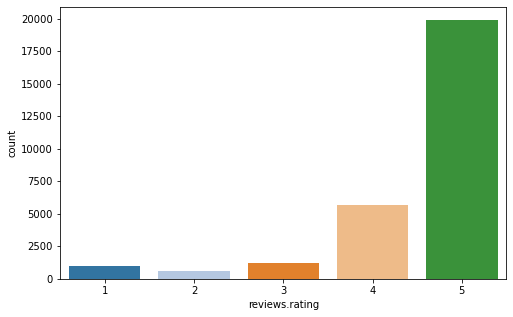

In [23]:
plt.figure(figsize=(8,5))
sns.countplot(x='reviews.rating', data=df, palette="tab20", dodge=False);

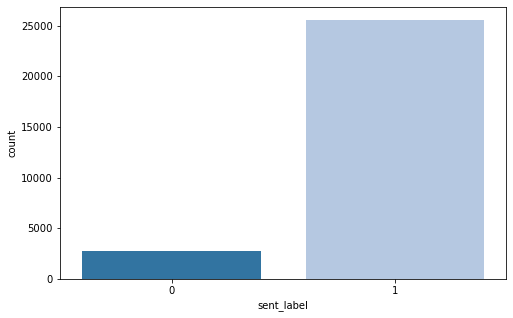

In [24]:
plt.figure(figsize=(8,5))
sns.countplot(x='sent_label', data=df, palette="tab20", dodge=False);

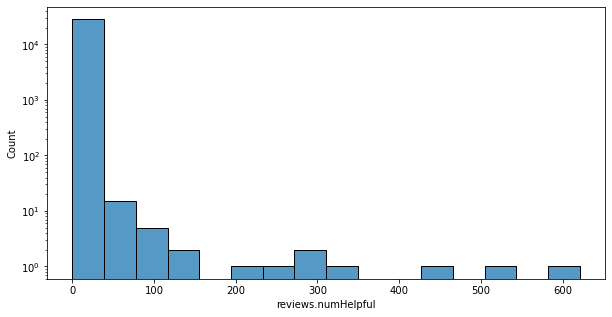

In [25]:
plt.figure(figsize=(10,5))
ax = sns.histplot(x='reviews.numHelpful', data=df, palette="tab20");
ax.set(yscale="log");

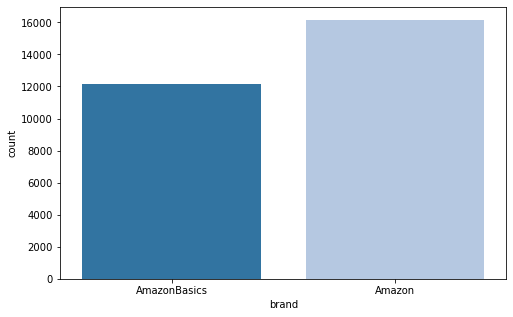

In [26]:
plt.figure(figsize=(8,5))
sns.countplot(x='brand', data=df, palette="tab20", dodge=False);

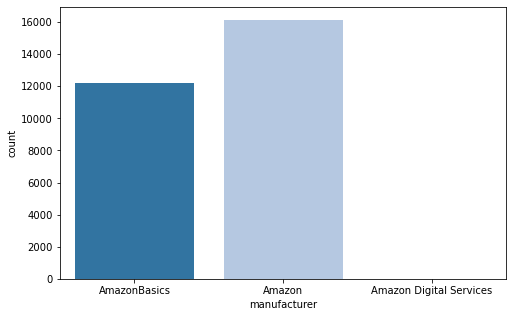

In [27]:
plt.figure(figsize=(8,5))
sns.countplot(x='manufacturer', data=df, palette="tab20", dodge=False);

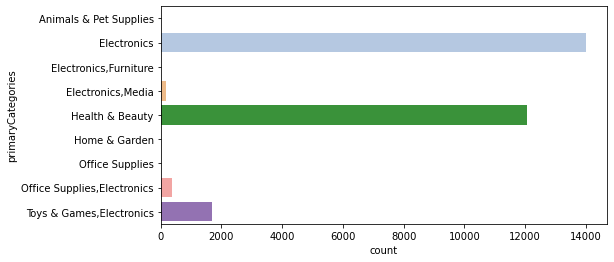

In [28]:
plt.figure(figsize=(8,4))
sns.countplot(y='primaryCategories', data=df, palette="tab20", orient='v');

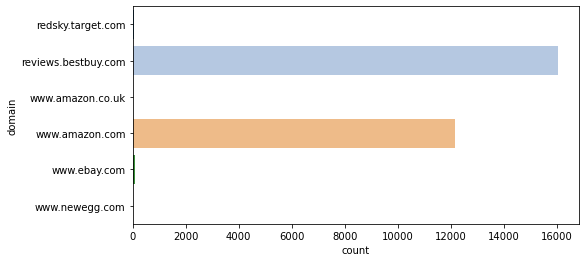

In [29]:
plt.figure(figsize=(8,4))
sns.countplot(y='domain', data=df, palette="tab20", orient='v');

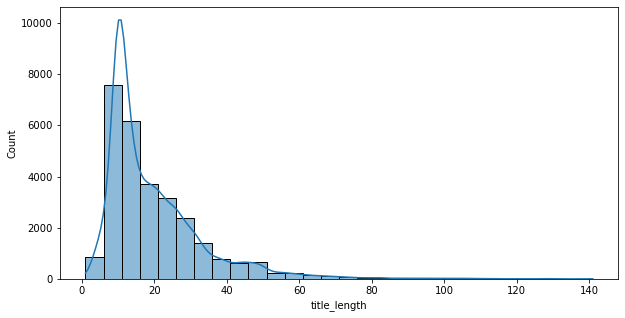

In [30]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='title_length', kde=True, palette="tab20c", binwidth=5);

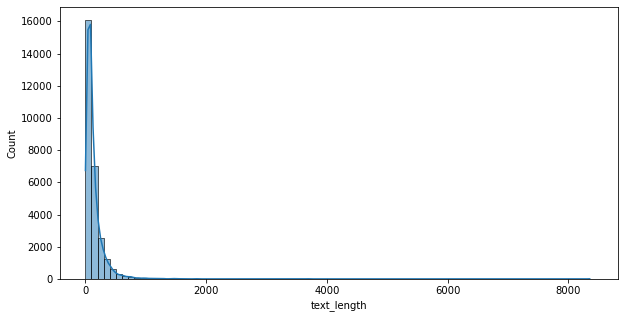

In [31]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='text_length', kde=True, palette="tab20c", binwidth=100);

# Preprocessing

In [32]:
df['reviews.text'][0]

'I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.'

In [33]:
def process_string(text):
    
    final_string = ""
    
    text = text.lower()
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
    useless_words = useless_words + ['.', ',', '!', "'"]
    text_filtered = [word for word in text if not word in useless_words]
    
    stemmer = PorterStemmer() 
    text_stemmed = [stemmer.stem(y) for y in text_filtered]
        
    for word in text_stemmed:
        final_string += word + " "
    
    return final_string

In [34]:
df['reviews.text'] = df['reviews.text'].apply(lambda x: process_string(x))

In [35]:
df['reviews.text'][0]

'order 3 one item bad qualiti miss backup spring put pc aluminum make batteri work '

In [36]:
# Tokenize the words
df['reviews.text.tok'] = df['reviews.text'].apply(word_tokenize)

In [37]:
df_pos = df[df['sent_label'] == 1]
df_neg = df[df['sent_label'] == 0]

In [38]:
freq_stats = []
for i in df_pos['reviews.text.tok']:
    freq_stats = freq_stats + i

In [39]:
fdist_ham = FreqDist(freq_stats)
fdist_ham.most_common(20)

[('great', 9095),
 ('batteri', 8080),
 ('tablet', 6729),
 ('love', 6101),
 ('use', 6085),
 ('good', 5361),
 ('price', 5117),
 ('work', 4003),
 ('amazon', 3284),
 ('kindl', 2867),
 ('easi', 2837),
 ('bought', 2820),
 ('kid', 2744),
 ('one', 2742),
 ('like', 2504),
 ('buy', 2389),
 ('last', 2299),
 ('well', 2285),
 ('read', 2244),
 ('purchas', 2242)]

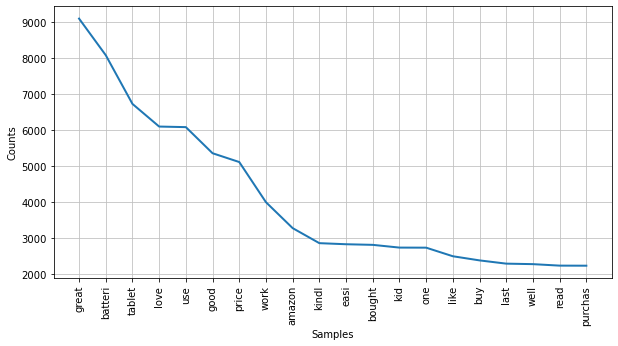

In [40]:
plt.figure(figsize=(10, 5))
fdist_ham.plot(20, cumulative=False)
plt.show()

In [41]:
freq_stats = []
for i in df_neg['reviews.text.tok']:
    freq_stats = freq_stats + i

In [42]:
fdist_ham = FreqDist(freq_stats)
fdist_ham.most_common(20)

[('batteri', 2057),
 ('use', 872),
 ('last', 855),
 ('work', 588),
 ('amazon', 580),
 ('tablet', 566),
 ('good', 495),
 ('dont', 493),
 ('long', 452),
 ('one', 436),
 ('get', 423),
 ('buy', 409),
 ('time', 371),
 ('like', 358),
 ('bought', 354),
 ('would', 335),
 ('purchas', 316),
 ('brand', 307),
 ('app', 281),
 ('price', 277)]

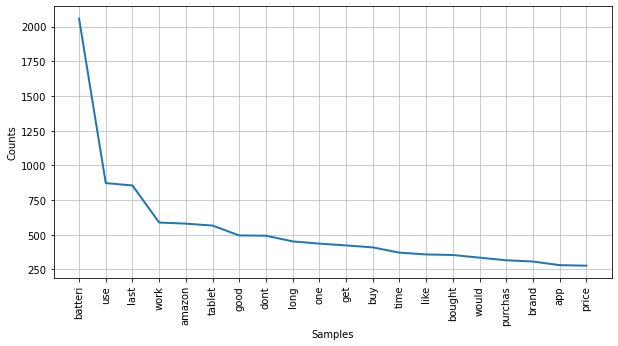

In [43]:
plt.figure(figsize=(10, 5))
fdist_ham.plot(20, cumulative=False)
plt.show()

# Machine learning

The process for completing the Machine Learning portion of the workflow will follow the below diagram from Scikit-Learn.

The general process is the following:

1. **Pipeline Creation**: Here the overall setup for preprocessing will be captured in a sklearn pipeline, helping chain everything together and making the process repeatable.
1. **Cross Validation for Model Selection**: Here, four different models will be run across a `RepeatedStratifiedKFold` process where different "fold" or sections of the model are trained and tested against different algorithms. 
1. **Hyperparameter Optimization**:  Using a Grid Seach Cross Validation, testing each of the above four algorithms for which parameters give the best results.
1. **Model Training and Valdation**: Each model with the new parameters is then run against the training and test data for final performance evaluation.


**Note on Feature Selection:** Some cursory work on feature selection was done testing the different models, but an exhaustive slection was not performed for the sake of time / assignment.  Normally this would be done as well to determine the features that have the largest impact on model performance. 

![workflow](https://raw.githubusercontent.com/broepke/DATA110/main/Week%2010/workflow.png)

## Train Test Split

In [44]:
X = df.drop(columns=['sent_label'])
y = df['sent_label']

# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

In [45]:
print(y_train.shape)
print(X_train.shape)

(18982,)
(18982, 17)


## Cross Validation

**Model Choices:**  

We know from the EDA above that the dataset is highly imbalanced.  Rather than balancing with SMOTE or over/under sampling, we'll specifically explore classifiers that are suitable for imbalanced data.  Either with flags (`class_weight`) or by the nature of their algorithm.

 - **Support Vector Classifier**: A widely used agorithm that's simple and performs well on high dimentionality datasets.  It can be used as a regression or a classification algorithm[1].
 - **Compliment Naive Bayes**: CNB is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets[2].
 - **LogisticRegresion:** Contains many hyper parameters for working with different datasets.  In addition to the `class_weight` parameter, it contains the abiliyt to leverage different solvers for different needs[3].  
 - **Random Forest**: Supports imbalanced data via the `class_weight` parameter[4].
 
 
1. https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47
2. https://scikit-learn.org/stable/modules/naive_bayes.html#complement-naive-bayes
3. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic%20regression#sklearn.linear_model.LogisticRegression
4. https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/

## Create Pipelines

In [46]:
def col_trans():
    column_trans = ColumnTransformer(
            [('primaryCategories', OneHotEncoder(dtype='int'),['primaryCategories']),
             ('manufacturer', OneHotEncoder(dtype='int'),['manufacturer']),
             ('domain', OneHotEncoder(dtype='int'),['domain']),
             ('numHelpful', MinMaxScaler(), ['reviews.numHelpful']),
             ('title', TfidfVectorizer(stop_words='english'), 'reviews.title'),
             ('text', TfidfVectorizer(stop_words='english'), 'reviews.text')],
            remainder='drop') 
    
    return column_trans

In [47]:
def create_pipe(clf):
    '''Create a pipeline for a given classifier.  The classifier needs to be an instance
    of the classifier with all parmeters needed specified.'''
    
    # Each pipeline uses the same column transformer.  
    column_trans = col_trans()
    
    pipeline = Pipeline([('prep',column_trans), ('clf', clf)])
     
    return pipeline

## Cross Validation for Model Selection

In [48]:
models = {'SVC' : SVC(class_weight='balanced', random_state=42),
         'ComplementNB' : ComplementNB(),
         'LogReg' : LogisticRegression(random_state=42, class_weight='balanced', max_iter=500),
         'RandomForest' : RandomForestClassifier(class_weight='balanced', random_state=42)}

for name, model, in models.items():
    clf = model
    pipeline = create_pipe(clf)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    print(name, ': Mean ROC-AUC: %.3f and Standard Deviation: (%.3f)' % (np.mean(scores), np.std(scores)))

SVC : Mean ROC-AUC: 0.967 and Standard Deviation: (0.006)
ComplementNB : Mean ROC-AUC: 0.898 and Standard Deviation: (0.011)
LogReg : Mean ROC-AUC: 0.960 and Standard Deviation: (0.006)
RandomForest : Mean ROC-AUC: 0.973 and Standard Deviation: (0.005)


The scoring metric used is ROC-AUC which takes into account. 

The best performing model of these for is the `RandomForestClassifier`.  After all tuning and train-test validation we'll see if it still is the best performing.

## Hyperparameter Optimization

In [49]:
def get_params(parameters, X, y, model):
    
    clf = GridSearchCV(model, parameters, n_jobs=-1)
    clf.fit(X, y)

    # extract the best alpha score
    return clf.best_params_

In [50]:
parameters = {'alpha': np.linspace(1,5,50)}
column_trans = col_trans()

clf = ComplementNB()
X_p = column_trans.fit_transform(X_train)
get_params(parameters, X_p, y_train, clf)

{'alpha': 1.8979591836734693}

In [51]:
parameters = [{'C': [5000, 5500], 
               'gamma': [.5, .1], 
               'class_weight' : ['balanced']}]
column_trans = col_trans()

clf = SVC()
X_p = column_trans.fit_transform(X_train)

get_params(parameters, X_p, y_train, clf)

{'C': 5000, 'class_weight': 'balanced', 'gamma': 0.5}

In [52]:
parameters = [{'class_weight' : ['balanced'],
               'max_iter' : [1000],
               'solver' : ['newton-cg', 'lbfgs', 'sag'],
               'C' : np.linspace(50,55,5)}]
column_trans = col_trans()

clf = LogisticRegression()
X_p = column_trans.fit_transform(X_train)

get_params(parameters, X_p, y_train, clf)

{'C': 53.75, 'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'sag'}

In [53]:
parameters = [{'class_weight' : ['balanced'],
              'criterion' : ["gini", "entropy"]}]
column_trans = col_trans()
clf = RandomForestClassifier()
X_p = column_trans.fit_transform(X_train)

get_params(parameters, X_p, y_train, clf)

{'class_weight': 'balanced', 'criterion': 'entropy'}

## Model Validation

In [54]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

In [70]:
def fit_and_print(pipeline):
    ''' take a supplied pipeline and run it against the train-test spit 
    and product scoring results.'''
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = metrics.f1_score(y_test, y_pred)

    print(metrics.classification_report(y_test, y_pred, digits=3))

    print("ROC-AUC Score:   %0.3f" % score, '\n')
    cm = metrics.confusion_matrix(y_test, y_pred, labels=[0,1])
    plot_confusion_matrix(cm, classes=[0,1])

              precision    recall  f1-score   support

           0      0.880     0.666     0.758       915
           1      0.965     0.990     0.977      8435

    accuracy                          0.958      9350
   macro avg      0.922     0.828     0.868      9350
weighted avg      0.956     0.958     0.956      9350

ROC-AUC Score:   0.977 

Confusion matrix, without normalization


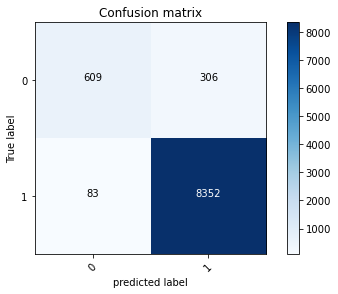

In [71]:
# {'C': 5000, 'class_weight': 'balanced', 'gamma': 0.5, 'kernel': 'rbf'}
clf = SVC(C=5000, gamma=0.5, class_weight='balanced', random_state=42)
pipeline = create_pipe(clf)
fit_and_print(pipeline)

              precision    recall  f1-score   support

           0      0.776     0.416     0.542       915
           1      0.940     0.987     0.963      8435

    accuracy                          0.931      9350
   macro avg      0.858     0.702     0.752      9350
weighted avg      0.924     0.931     0.922      9350

ROC-AUC Score:   0.963 

Confusion matrix, without normalization


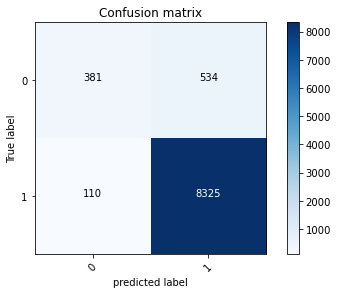

In [72]:
clf = ComplementNB(alpha=1.9)
pipeline = create_pipe(clf)
fit_and_print(pipeline)

              precision    recall  f1-score   support

           0      0.629     0.798     0.703       915
           1      0.977     0.949     0.963      8435

    accuracy                          0.934      9350
   macro avg      0.803     0.873     0.833      9350
weighted avg      0.943     0.934     0.938      9350

ROC-AUC Score:   0.963 

Confusion matrix, without normalization


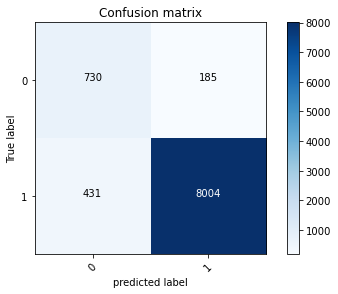

In [73]:
# {'C': 51.25, 'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'sag'}
clf = LogisticRegression(C=51.25, solver='sag', random_state=42, class_weight='balanced', max_iter=1000)
pipeline = create_pipe(clf)
fit_and_print(pipeline)

              precision    recall  f1-score   support

           0      0.933     0.605     0.734       915
           1      0.959     0.995     0.977      8435

    accuracy                          0.957      9350
   macro avg      0.946     0.800     0.855      9350
weighted avg      0.956     0.957     0.953      9350

ROC-AUC Score:   0.977 

Confusion matrix, without normalization


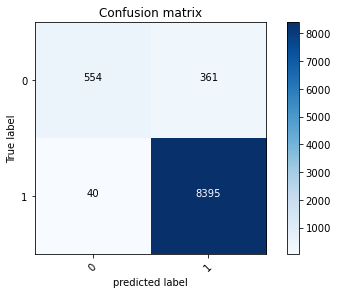

In [74]:
# {'class_weight': 'balanced', 'criterion': 'entropy'}
clf = RandomForestClassifier(criterion='entropy', class_weight='balanced', random_state=42)
pipeline = create_pipe(clf)
fit_and_print(pipeline)

# Sentiment Analysis

In [60]:
sid = SentimentIntensityAnalyzer()

In [61]:
# Apply the Polarity Scoring from Vader
df['vader'] = df['reviews.text'].apply(lambda review: sid.polarity_scores(review))

# Create a few extra columns to aid in the analysis
df['compound'] = df['vader'].apply(lambda score_dict: score_dict['compound'])
df['vader_score'] = df['compound'].apply(lambda c: 'pos' if c > 0 else ('neu' if c == 0 else 'neg'))
df['vader_label'] = df['compound'].apply(lambda c: 1 if c >= 0 else 0)

In [62]:
df[df.columns[-6:]].head()

,sent_label,reviews.text.tok,vader,compound,vader_score,vader_label
0,0,"[order, 3, one, item, bad, qualiti, miss, back...","{'neg': 0.298, 'neu': 0.702, 'pos': 0.0, 'comp...",-0.6249,neg,0
1,1,"[bulk, alway, less, expens, way, go, product, ...","{'neg': 0.0, 'neu': 0.737, 'pos': 0.263, 'comp...",0.3612,pos,1
2,1,"[well, duracel, price, happi]","{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'comp...",0.2732,pos,1
3,1,"[seem, work, well, name, brand, batteri, much,...","{'neg': 0.0, 'neu': 0.583, 'pos': 0.417, 'comp...",0.6124,pos,1
4,1,"[batteri, long, last, price, great]","{'neg': 0.0, 'neu': 0.494, 'pos': 0.506, 'comp...",0.6249,pos,1


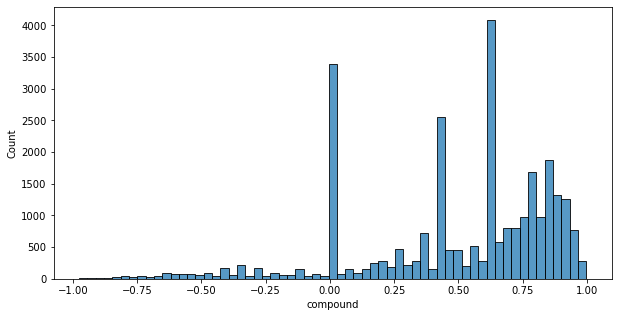

In [63]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='compound', palette="tab20c");

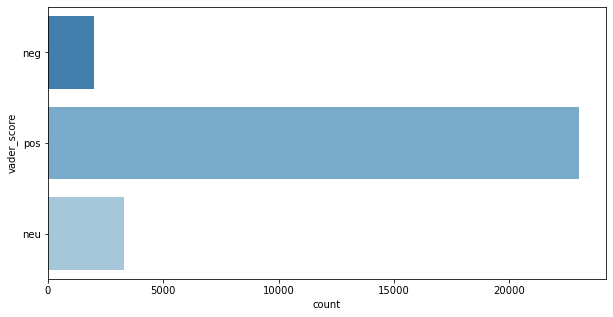

In [64]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, y='vader_score', palette="tab20c");

## Validating Sentiment Predictions

              precision    recall  f1-score   support

           0      0.423     0.304     0.354      2787
           1      0.926     0.955     0.940     25545

    accuracy                          0.891     28332
   macro avg      0.675     0.629     0.647     28332
weighted avg      0.877     0.891     0.883     28332


Confusion matrix, without normalization


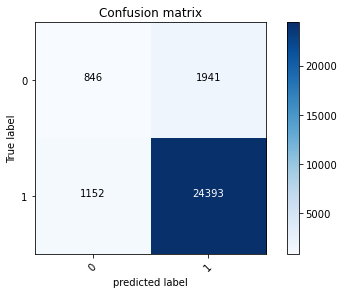

In [65]:
print(metrics.classification_report(df['sent_label'], df['vader_label'], digits=3))
print('')

cm = metrics.confusion_matrix(df['sent_label'], df['vader_label'], labels=[0,1])
plot_confusion_matrix(cm, classes=[0,1])

# Word Clouds

In [66]:
df_pos = df[df['vader_score'] == 'pos']
df_neg = df[df['vader_score'] == 'neg']

In [67]:
def gen_word_cloud(text, from_col, cmap='viridis'):
    
    # lower max_font_size, change the maximum number of word and lighten the background:
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",\
                          scale=10, colormap=cmap).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
        
    return

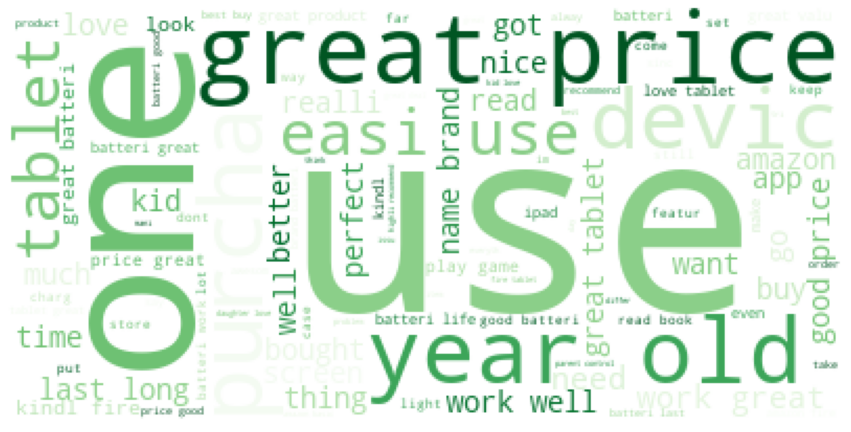

In [68]:
title = " ".join(word for word in df_pos['reviews.text'])

# Generate a word cloud image
wordcloud_pos = WordCloud(background_color="white", 
                            mode="RGBA", max_words=100, colormap='Greens').generate(title)

# create coloring from image
plt.figure(figsize=[15,15])
plt.imshow(wordcloud_pos)
plt.axis("off")

plt.show()

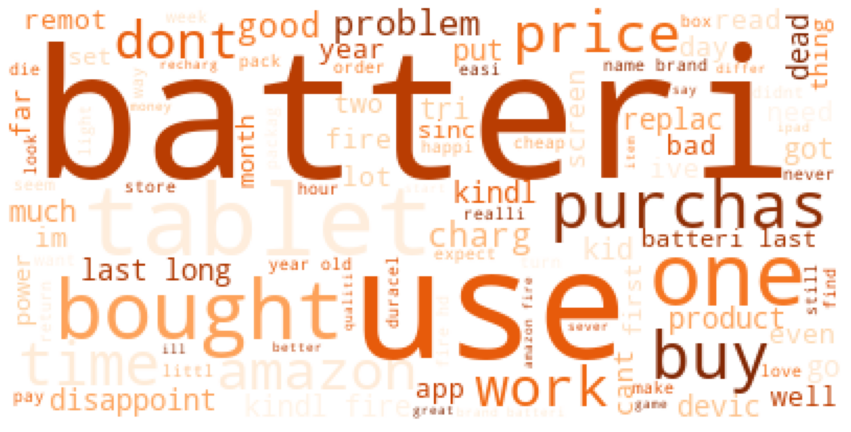

In [69]:
title = " ".join(word for word in df_neg['reviews.text'])

# Generate a word cloud image
wordcloud_neg = WordCloud(background_color="white", 
                            mode="RGBA", max_words=100, colormap='Oranges').generate(title)

# create coloring from image
plt.figure(figsize=[15,15])
plt.imshow(wordcloud_neg)
plt.axis("off")

plt.show()